In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import skimage
import shutil
import torch
import json
import cv2

from pathlib import Path
from collections import Counter
from tqdm.auto import trange, tqdm
from torchvision import datasets, models, transforms

# Data processing

## Load Test Data

In [2]:
test_categories_df = pd.read_csv("https://raw.githubusercontent.com/chenlh0/product-classification-challenge/master/product_categories.txt", header=None, index_col=None)[0]
test_products_df = pd.read_json("https://raw.githubusercontent.com/chenlh0/product-classification-challenge/master/product_data.json")

In [3]:
Path("./test_dataset").mkdir(parents=True, exist_ok=True)

def download_image(url):
    response = requests.get(url)
    file_path = f"./test_dataset/{url.split('/')[-1]}"
    img_bytes = np.frombuffer(response.content, np.uint8)
    cv2.imwrite(file_path, cv2.imdecode(img_bytes, cv2.IMREAD_COLOR))
    return file_path

In [4]:
test_products_df = test_products_df.assign(
    img_path=test_products_df.image_url.apply(download_image)
).drop(columns="image_url")

## Load Train data

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [6]:
import kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files('paramaggarwal/fashion-product-images-small', path='./train_val_dataset/', unzip=True)

train_val_products_df = pd.read_csv("./train_val_dataset/styles.csv", error_bad_lines=False)

train_val_products_df = train_val_products_df\
    .get(["productDisplayName", "subCategory", "id"])\
    .rename(columns={"productDisplayName": "description", "subCategory": "category"})\
    .set_index("id")

train_val_products_df = train_val_products_df[train_val_products_df["description"].notna()] 

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

## Train-Val Split

In [7]:
VALIDATION_PROPORTION = 0.15

val_ids = train_val_products_df.groupby("category").sample(frac=VALIDATION_PROPORTION).index
train_val_products_df.loc[:, "set"] = "train"
train_val_products_df.loc[val_ids, "set"] = "val"

# Prepare train/validation files

In [8]:
for category in train_val_products_df["category"].unique():
    Path(f"train_dataset/{category}").mkdir(parents=True, exist_ok=True)
    Path(f"val_dataset/{category}").mkdir(parents=True, exist_ok=True)

In [9]:
img_paths = train_val_products_df.apply(
    lambda r: f'./{r["set"]}_dataset/{r["category"]}/{r.name}.jpg', 
    axis=1)

img_missing = []
for img_id, img_path in tqdm(img_paths.items(), total=len(img_paths)):
    old_path = Path(f"./train_val_dataset/images/{img_id}.jpg")
    new_path = Path(img_path)
    
    if not old_path.exists():
        img_missing.append(img_id)
        continue

    shutil.copy(old_path, new_path)

train_val_products_df.drop(img_missing, inplace=True)

  0%|          | 0/44417 [00:00<?, ?it/s]

Create a random images for empty classes

In [10]:
for category in train_val_products_df["category"].unique():
    is_val_category_empty = not any(Path(f"val_dataset/{category}").iterdir())
    if is_val_category_empty:
        cv2.imwrite(f"val_dataset/{category}/0.jpg", np.random.randint(256, size=(80, 60, 3)))
    is_train_category_empty = not any(Path(f"train_dataset/{category}").iterdir())
    if is_train_category_empty:
        cv2.imwrite(f"train_dataset/{category}/0.jpg", np.random.randint(256, size=(80, 60, 3)))

## Create pytorch sampler and dataloader

In [66]:
train_dataset = datasets.ImageFolder(
        "./train_dataset/",
        transforms.Compose([
            transforms.RandomResizedCrop(256),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))

labels = pd.Series(Counter(train_dataset.targets))
class_weights = (1 / (labels**(1/7))).to_dict()
sample_class_weight = np.vectorize(lambda c: class_weights[c])(train_dataset.targets)

train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_class_weight,
    num_samples=len(train_dataset),
    replacement=True,
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)

In [67]:
val_dataset = datasets.ImageFolder(
        "./val_dataset/",
        transforms.Compose([
            transforms.Resize(256),
            # transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1)


# Define classifier model
<!-- Fine Tunning MobileNetV2 for classification -->

In [68]:
N_TRAIN_CLASSES = len(class_weights)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Freeze model and replace last layer

In [69]:
model = models.mobilenet_v2(pretrained=True).to(device)

# Freezes the model for fine-tuning
for param in model.parameters():
    param.requires_grad = False

# Add new classifier layer for finetunning. Using a densely connected layer
model.classifier[-1] = torch.nn.Linear(1280, N_TRAIN_CLASSES).to(device)

params_to_update = list(filter(lambda param: param.requires_grad, model.parameters()))

## Training


In [70]:
# optimizer = torch.optim.Adam(params_to_update, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss().float().to(device)

In [71]:
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    accumulated_loss = 0
    accumulated_corrects = 0

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, dim=1)

        accumulated_loss += loss.item()
        accumulated_corrects += torch.sum(preds == labels.data)

    epoch_loss = accumulated_loss / len(dataloader.dataset)
    epoch_acc = accumulated_corrects.double() / len(dataloader.dataset)
    return {"loss": epoch_loss, "acc": epoch_acc}

In [72]:
def validate_model(model, dataloader, criterion, device):
    model.eval()
    accumulated_loss = 0
    accumulated_corrects = 0

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, dim=1)

        accumulated_loss += loss.item()
        accumulated_corrects += torch.sum(preds == labels.data)

    epoch_loss = accumulated_loss / len(dataloader.dataset)
    epoch_acc = accumulated_corrects.double() / len(dataloader.dataset)
    return {"loss": epoch_loss, "acc": epoch_acc}

Early stopping the train (epoch 12) so it won't overfit too much on this train dataset, which is totally different from the test dataset.

In [73]:
from collections import defaultdict
num_epochs = 12
metrics = defaultdict(list)

for epoch in trange(num_epochs):
    train_metric = train_model(model, train_dataloader, optimizer, criterion, device)
    metrics["train"].append(train_metric)
    print(f"train_metric {train_metric}")
    val_metric = validate_model(model, val_dataloader, criterion, device)
    metrics["val"].append(val_metric)
    print(f"val_metric {val_metric}")

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.026197515271357354, 'acc': tensor(0.5892, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.9549402376604724, 'acc': tensor(0.8098, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.018528065755667275, 'acc': tensor(0.6963, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.7822403302204685, 'acc': tensor(0.8459, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.01670239308811971, 'acc': tensor(0.7206, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.6940176708314171, 'acc': tensor(0.8588, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.01571807192650852, 'acc': tensor(0.7323, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.6221080390758643, 'acc': tensor(0.8629, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.015124858979357789, 'acc': tensor(0.7394, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.5870526494675298, 'acc': tensor(0.8657, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.01470812594969541, 'acc': tensor(0.7444, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.5656769526680537, 'acc': tensor(0.8674, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.014356925291730868, 'acc': tensor(0.7451, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.552298096126966, 'acc': tensor(0.8734, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.014144048935530201, 'acc': tensor(0.7512, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.5388706642494355, 'acc': tensor(0.8782, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.013800822540624253, 'acc': tensor(0.7515, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.507516884749955, 'acc': tensor(0.8794, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.013447771613171558, 'acc': tensor(0.7595, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.502730277319798, 'acc': tensor(0.8816, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.013299267928331892, 'acc': tensor(0.7602, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.4991869573434439, 'acc': tensor(0.8848, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/590 [00:00<?, ?it/s]

train_metric {'loss': 0.013186319123830227, 'acc': tensor(0.7618, device='cuda:0', dtype=torch.float64)}


  0%|          | 0/6665 [00:00<?, ?it/s]

val_metric {'loss': 0.49400813798784965, 'acc': tensor(0.8812, device='cuda:0', dtype=torch.float64)}


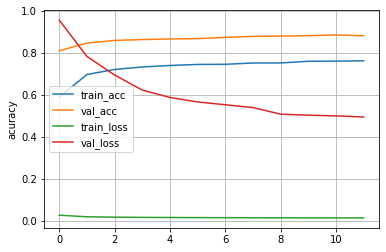

In [84]:
train_loss = [train_metric["loss"] for train_metric in metrics["train"]] 
val_loss = [val_metric["loss"] for val_metric in metrics["val"]] 
train_acc = [train_metric["acc"] for train_metric in metrics["train"]]
val_acc = [val_metric["acc"] for val_metric in metrics["val"]]
f, ax = plt.subplots()
ax.plot(train_acc, label="train_acc")
ax.plot(val_acc, label="val_acc")
ax.set_ylabel("acuracy")
ax.plot(train_loss, label="train_loss")
ax.plot(val_loss, label="val_loss")
ax.legend()
ax.grid()

In [76]:
model.eval()

set_outputs = []
for inputs, _ in tqdm(val_dataloader):
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    set_outputs.extend(preds.cpu().numpy())
set_outputs = np.array(set_outputs)

  0%|          | 0/6665 [00:00<?, ?it/s]

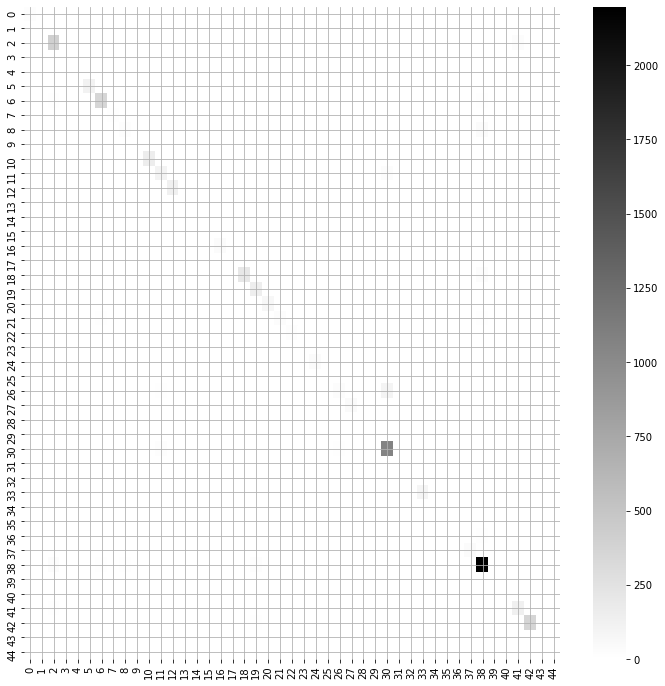

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
plt.figure(figsize=(12, 12))
sn.heatmap(confusion_matrix(val_dataloader.dataset.targets, set_outputs), cmap='binary')
plt.grid()

In [86]:
from google.colab import drive
drive.mount('/content/gdrive')

torch.save(model.state_dict(), "/content/gdrive/MyDrive/image_categorization.pt")

Done!